In [1]:
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import imblearn as imb
from imblearn.under_sampling import RandomUnderSampler

import scipy


In [2]:
# Open img-scout dfs

data_dir = '/Users/kathleenkanaley/Desktop/grapes_from_space/data/'
data_20 = pd.read_csv(data_dir +'img_scout_dfs/2020/smr_vis_skysat_scout_2020.csv').dropna()
data_21 = pd.read_csv(data_dir +'img_scout_dfs/2021/smr_vis_skysat_scout_2021.csv').dropna()
data_22 = pd.read_csv(data_dir +'img_scout_dfs/2022/smr_vis_skysat_scout_2022.csv').dropna()

data_21 = data_21[data_21['Date']!='2021-08-03']
data_20 = data_20[data_20['Date']!='2020-09-09']

img_dfs = [data_20, data_21, data_22]
all_years = pd.concat(img_dfs)

In [3]:
all_years.Date.unique()

array(['2020-06-18', '2020-06-25', '2020-07-09', '2020-08-06',
       '2020-08-13', '2021-07-07', '2021-07-27', '2021-08-10',
       '2021-08-17', '2022-06-22', '2022-07-06', '2022-07-20'],
      dtype=object)

In [4]:
all_years['GDM_sev']='low'
all_years.loc[all_years['DM_severity'] > 10, 'GDM_sev'] = 'high'
    
all_years['GDM_inc']='low'
all_years.loc[all_years['DM_inc'] > 25, 'GDM_inc'] = 'high'

In [5]:
all_years.columns

Index(['acquired', 'plot', 'blue', 'green', 'red', 'nir', 'veg_smr',
       'savi_exp', 'savi', 'msavi', 'evi', 'arvi', 'gri', 'ndvi', 'nir_blue',
       'nir_green', 'red_blue', 'green_red', 'green_blue', 'row', 'panel',
       'Date', 'Treatment', 'Block', 'PM_severity', 'DM_severity', 'total_dis',
       'geometry', 'centroid', 'PM_inc', 'DM_inc', 'GDM_sev', 'GDM_inc'],
      dtype='object')

In [6]:
# SB  
expl_vars = ['blue', 'green', 'red', 'nir']
resp_var = 'GDM_sev'

In [7]:
X = all_years[expl_vars]
y = all_years[resp_var]

rus = RandomUnderSampler(random_state=2020)
X_rus, y_rus = rus.fit_resample(X, y)

# Split dataset into training set and test set
SPLIT_RND_SEED = 456
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
                                                    test_size=0.3, 
                                                    random_state=SPLIT_RND_SEED,
                                                    stratify = y_rus)  # 70% training and 30% test

In [8]:
mm = MinMaxScaler()
X_train_scaled = mm.fit_transform(X_train)
X_test_scaled = mm.transform(X_test)
#y_train = np.array(y_train)

In [9]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)
display(rfc.score(X_train_scaled, y_train))

1.0

In [10]:
# Prediction on test data
y_pred = rfc.predict(X_test_scaled)

In [11]:
# Classification report
stats = classification_report(y_test, y_pred,
                              labels=None,
#                               target_names=["low", "high"],
                              sample_weight=None,
                              digits=2,
                              output_dict=False)
  
print("Classification report:\n")
print(stats)

Classification report:

              precision    recall  f1-score   support

        high       0.74      0.80      0.77        40
         low       0.78      0.72      0.75        40

    accuracy                           0.76        80
   macro avg       0.76      0.76      0.76        80
weighted avg       0.76      0.76      0.76        80



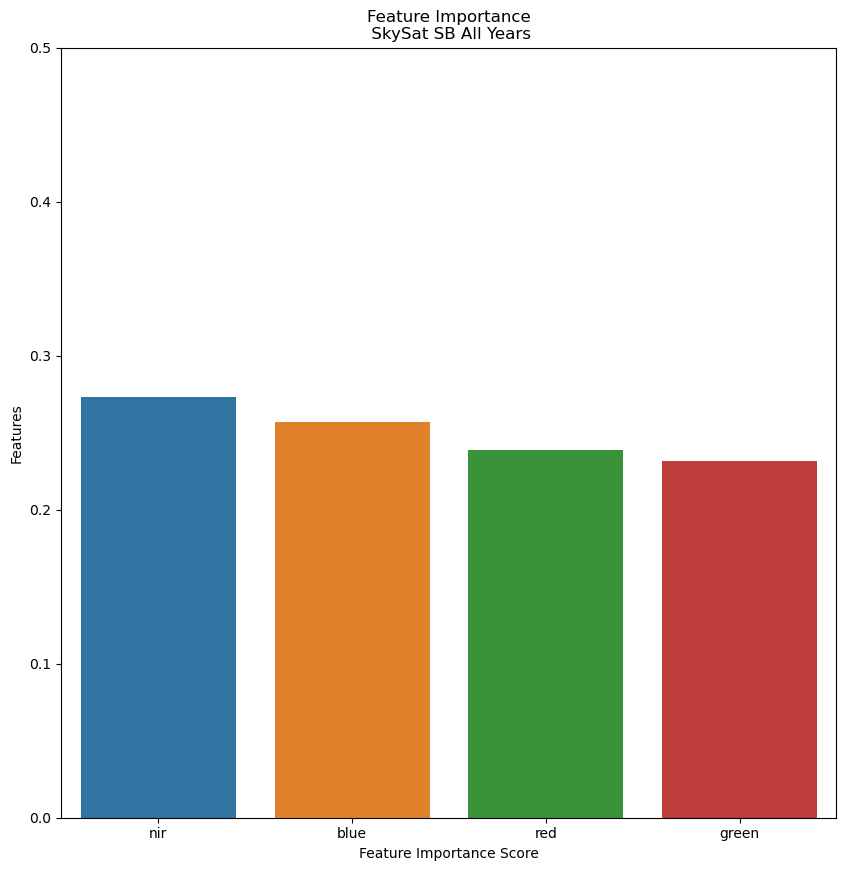

In [12]:
# view the feature scores
feature_scores_allyears = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores_allyears

# display the predictions
plt.rcParams['figure.figsize'] = [10, 10]

#palette = sns.color_palette("Greens")

# Creating a seaborn bar plot
sns.barplot(x=feature_scores_allyears.index, y=feature_scores_allyears)
plt.title("Feature Importance\n SkySat SB All Years")
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.ylim(0, 0.5)

# plt.savefig("feature_imp20.svg")
plt.show()


In [13]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000,
num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num =
15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50,
num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50,
num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

In [14]:
rs = RandomizedSearchCV(rfc,
param_dist,
n_iter = 100,
cv = 3,
verbose = 1,
n_jobs=-1,
random_state=0)

rs.fit(X_train_scaled, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 700,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 11,
 'bootstrap': True}

In [15]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
'mean_fit_time',
'std_fit_time',
'mean_score_time',
'std_score_time',
'params',
'split0_test_score',
'split1_test_score',
'split2_test_score',
'std_test_score'],
axis=1)

rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,700,2,2,log2,11,True,0.715054,1
1,600,23,2,sqrt,15,False,0.698925,2
2,400,23,2,sqrt,14,False,0.693548,3
3,700,12,2,sqrt,13,False,0.693548,3
4,700,18,7,sqrt,7,False,0.661290,5
5,200,12,2,log2,4,True,0.661290,5
6,800,18,39,log2,11,True,0.655914,7
7,100,18,23,sqrt,8,True,0.655914,7
8,800,28,39,log2,11,True,0.655914,7
9,300,18,39,log2,2,True,0.655914,7


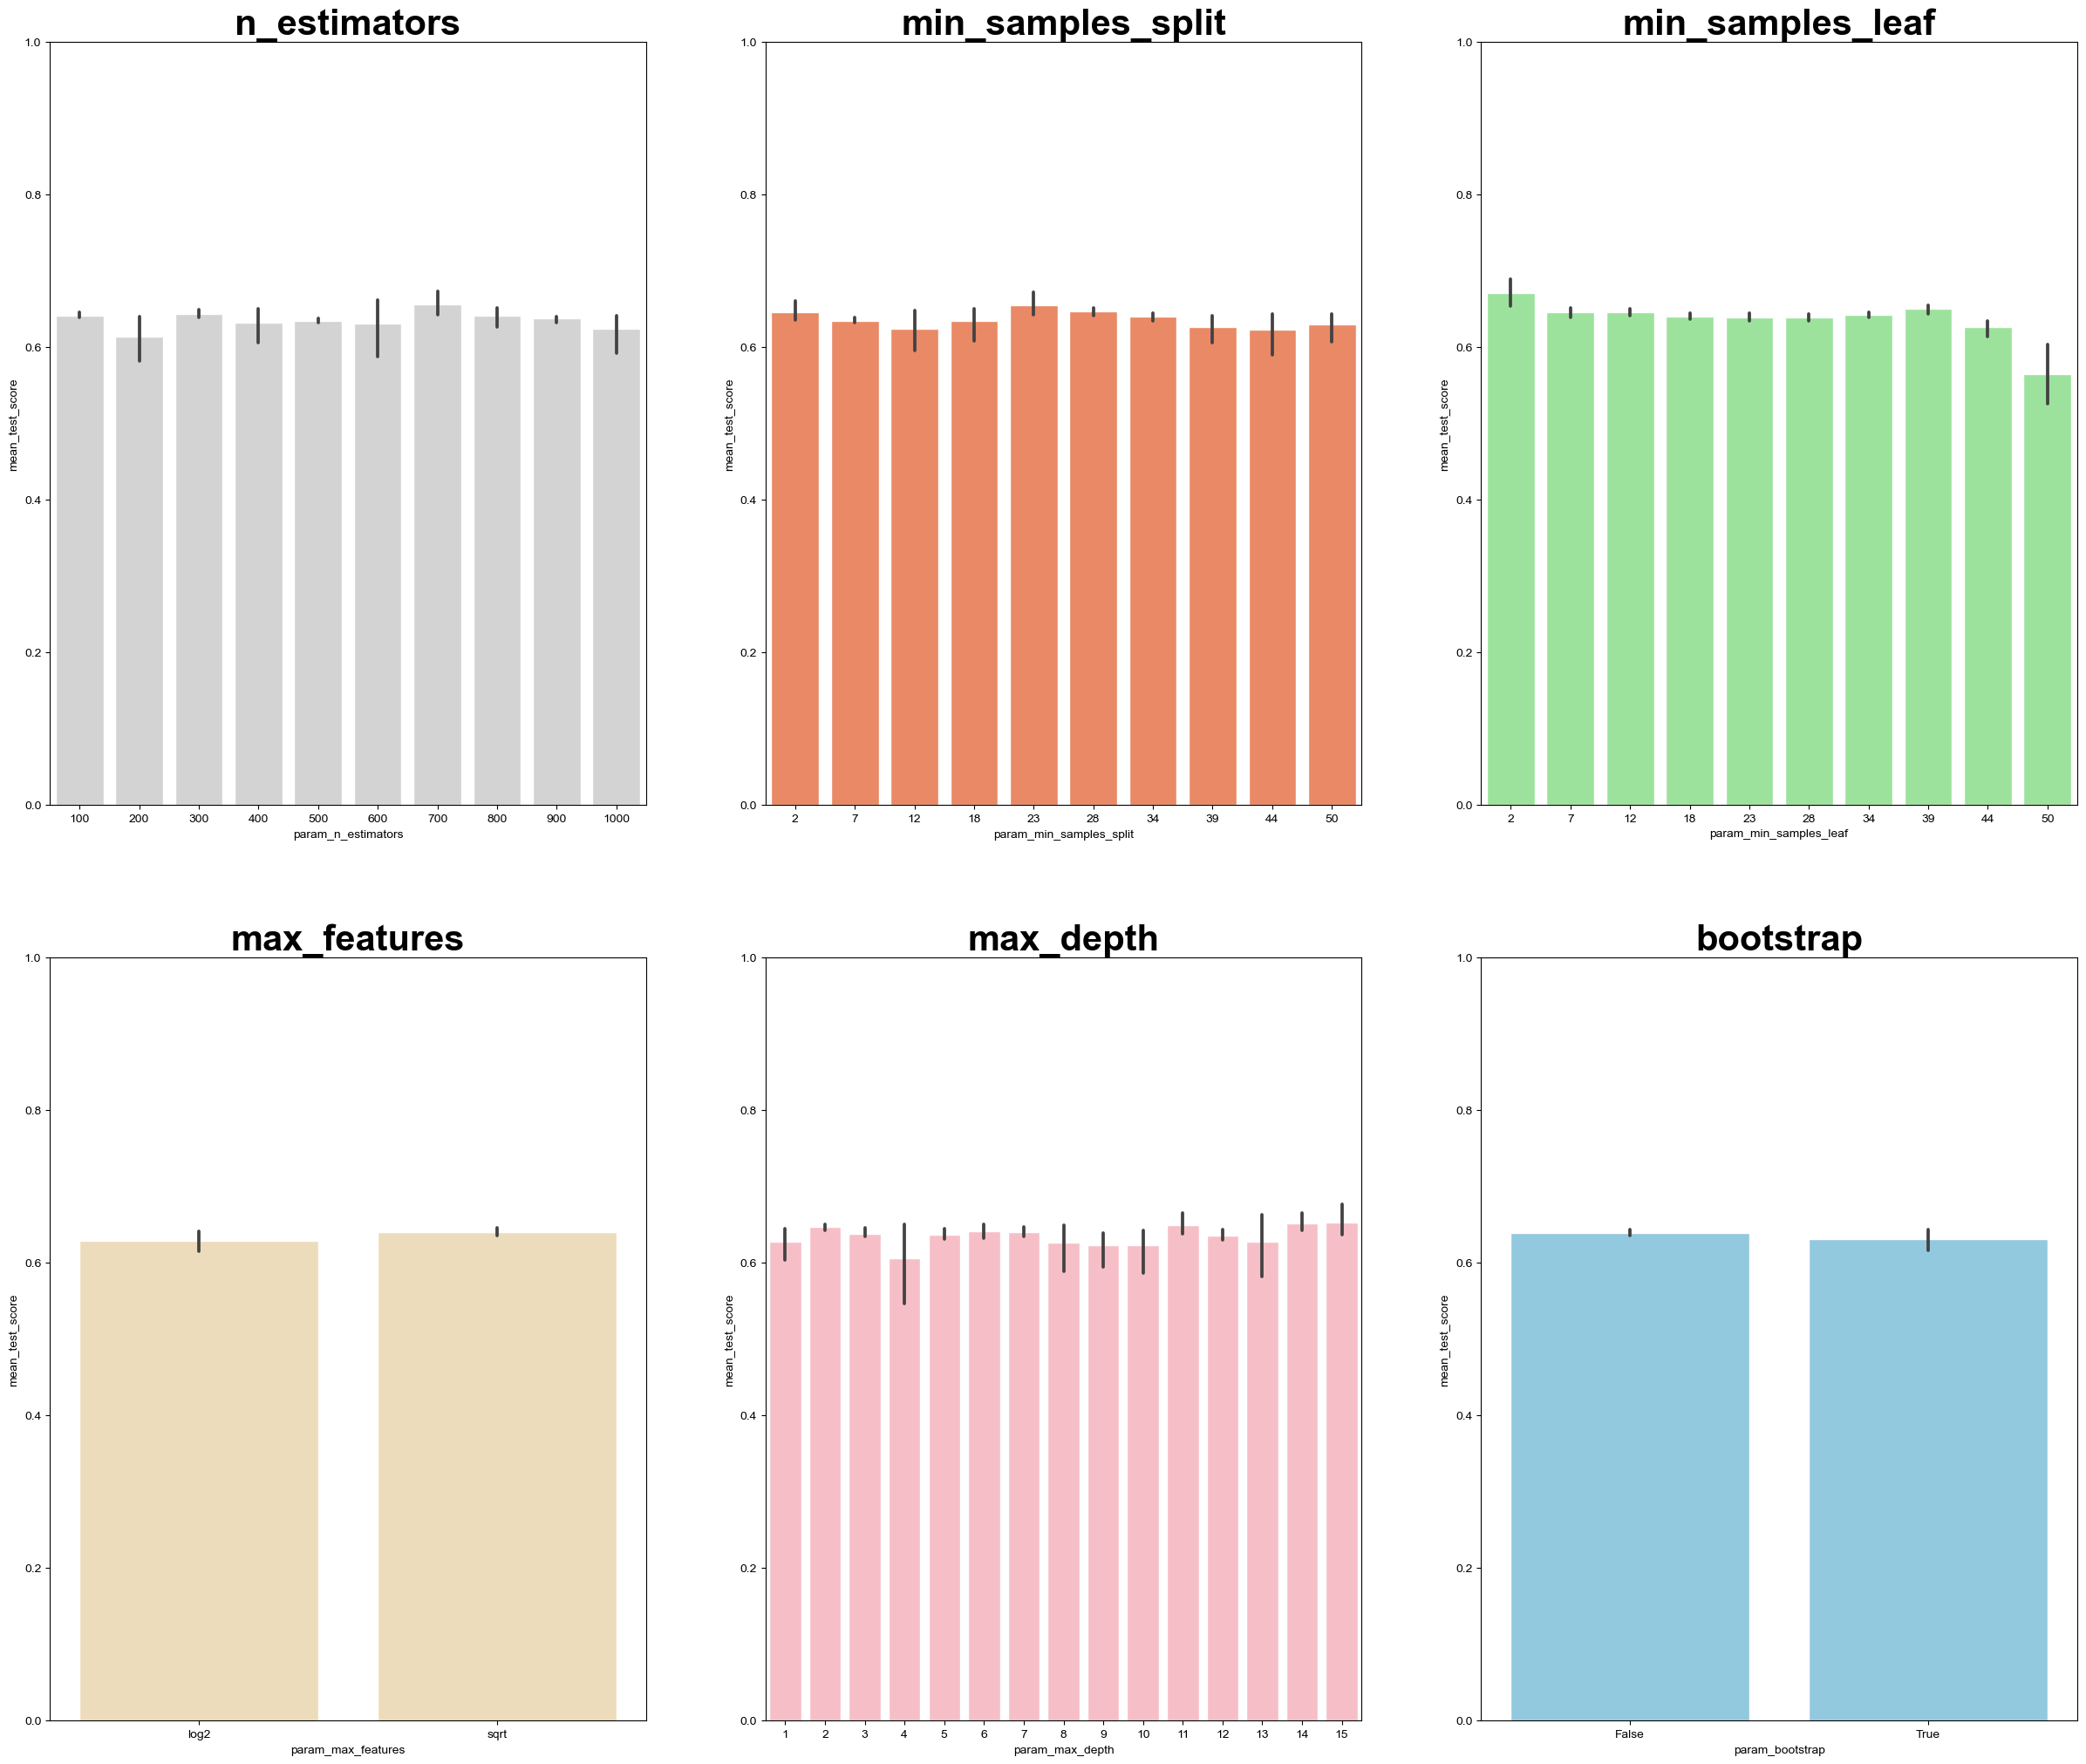

In [16]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df,
ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.0,1])
axs[0,0].set_title(label = 'n_estimators',
size=30, weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score',
data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.0,1])
axs[0,1].set_title(label =
'min_samples_split', size=30, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score',
data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.0,1])
axs[0,2].set_title(label =
'min_samples_leaf', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df,
ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.0,1])
axs[1,0].set_title(label = 'max_features',
size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df,
ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.0,1])
axs[1,1].set_title(label = 'max_depth',
size=30, weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df,
ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.0,1])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')

plt.show()

In [17]:
from sklearn.model_selection import GridSearchCV
n_estimators = [100,300,700]
max_features = ['sqrt','log2']
max_depth = [2,3,6,7,11,14,15]
min_samples_split = [2,23,28]
min_samples_leaf = [2,7]
bootstrap = [True,False]

param_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_scaled, y_train)
rfc_2 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 504 candidates, totalling 1512 fits


{'bootstrap': False,
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [18]:
y_pred = rfc.predict(X_test_scaled)

y_pred_gs = gs.best_estimator_.predict(X_test_scaled)

In [19]:
from sklearn.metrics import confusion_matrix

conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred),
index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                   
                                             

conf_matrix_tuned = pd.DataFrame(confusion_matrix(y_test, y_pred_gs),
        index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                                         
display(conf_matrix_baseline)
display('Baseline Random Forest accuracy score', accuracy_score(y_test, y_pred))
                                                         

display(conf_matrix_tuned)
display('Hyperparameter Tuned Random Forest accuracy score', accuracy_score(y_test, y_pred_gs))

,high,low
high,32,8
low,11,29


'Baseline Random Forest accuracy score'

0.7625

,high,low
high,30,10
low,11,29


'Hyperparameter Tuned Random Forest accuracy score'

0.7375

In [20]:
# Repeat with best performing model

In [21]:
def run_rf(df, expl_vars, resp_var, SPLIT_RND_SEED):
    X = df[expl_vars]
    y = df[resp_var]
    
    rus = RandomUnderSampler(random_state=2020)
    X_rus, y_rus = rus.fit_resample(X, y)

# Split dataset into training set and test set

    X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
                                                    test_size=0.3, 
                                                    random_state=SPLIT_RND_SEED,
                                                    stratify = y_rus)  # 70% training and 30% test
    mm = MinMaxScaler()
    X_train_scaled = mm.fit_transform(X_train)
    X_test_scaled = mm.transform(X_test)
    
    
    from sklearn.ensemble import RandomForestClassifier
    
    # Modify with best parameters  
    rf = RandomForestClassifier()
        
        
#                                 n_estimators = 500, 
#                                 oob_score=True, 
#                                 #random_state=rand_state, # random number to be used, needed to reproduce the same result
#                                 verbose=False)
    
    rf_model = rf.fit(X_train_scaled, y_train)
    
    y_pred = rf_model.predict(X_test_scaled)
    
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred)
    
    from sklearn.metrics import precision_recall_fscore_support
    
    prec, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
  
    
    from sklearn.metrics import cohen_kappa_score
        
    cohen_score = cohen_kappa_score(y_test, y_pred)    

    label_0 = np.unique(y_pred)[0]
    label_1 = np.unique(y_pred)[1]
    
    metrics = {
        'cohen_kappa': [cohen_score], 
        'accuracy_score': [accuracy],
        'precision {}'.format(label_0): [prec[0]],
        'precision {}'.format(label_1): [prec[1]],
        'recall {}'.format(label_0): [recall[0]],
        'recall {}'.format(label_1): [recall[1]],
        'fscore {}'.format(label_0): [fscore[0]],
        'fscore {}'.format(label_1): [fscore[1]],

    }
    metrics_df = pd.DataFrame(data=metrics)
    
    return metrics_df


In [22]:
run_rf(all_years, expl_vars, resp_var, 456)

,cohen_kappa,accuracy_score,precision high,precision low,recall high,recall low,fscore high,fscore low
0,0.475,0.7375,0.731707,0.74359,0.75,0.725,0.740741,0.734177


In [23]:
import random
 
rand_list=[]
n=100
for i in range(n):
    rand_list.append(random.randint(100,999))

In [24]:
# RF model, GDM Inc all years SB
expl_vars = ['blue', 'green', 'red', 'nir']
resp_var = 'GDM_sev'

results_alldata = []
for r in rand_list:
    res_df = run_rf(all_years, expl_vars, resp_var, r)
    
    results_alldata.append(res_df)

In [25]:
results_alldata_df = pd.concat(results_alldata)
results_alldata_df.mean()

cohen_kappa       0.505750
accuracy_score    0.752875
precision high    0.747128
precision low     0.766900
recall high       0.771250
recall low        0.734500
fscore high       0.756379
fscore low        0.747549
dtype: float64